## DynamicsAndControl.jl - Rocket Landing Tutorial

DynamicsAndControl.jl is an experimental Julia library for closed loop
simulation of complicated systems - vehicles, robots, or any system
characterized by continuous nonlinear dynamics and discrete control updates.

### Key features
* Quickly and easily build complicated simulations (complex dynamics,
discrete controllers running at various rates, sensor and actuator dynamics,
noise and disturbances, etc.)
* Simulation interface is at the "type" level - define struct types
(composite data structures) that can be integrated and updated directly,
without the need for manually indexing or serializing for numerical
integration
* Easily log and plot data from anywhere in the simulation - inside the
dynamics, the controller, or any other component
* High performance - core integration and update loop is type stable and
zero-allocating, and minimal runtime overhead for working with "struct"
abstractions

### Concepts

A simulation contain 4 core components: the *dynamics*, the *sensor*, the
*controller*, and the *actuator*:
* The dynamics represents the underlying
differential equations describing the physics
* The controller represents all
computations that occur on the vehicle/robot (estimation, control, etc.), and
runs in discrete time
* The sensor represents information flowing from the
dynamics to the controller, which runs in discrete time
* The actuator
represents information flowing from the controller to the dynamics, which
also runs in discrete time

DynamicsAndControl.jl lets you define each of these components and some
associated methods, and then run a closed-loop simulation of all the
components executing and interacting.

The rest of this tutorial will demonstrate the functionality and key concepts
of DynamicsAndControl.jl using a simple planar rocket landing example.

In [672]:
using Revise
using DynamicsAndControl
using StaticArrays
using Rotations
using OrdinaryDiffEq
using LinearAlgebra
using Plots; gr()

Plots.GRBackend()

### Planar Rocket Landing Simulation

Let's implement a simple planar rocket landing simulation. This will
represent a rocket with planar dynamics and attitude control doing a simple
gravity turn landing burn.

First, we'll define the dynamics using the @dynamics macro. We need to
specify the state space, consisting of an "integrable" portion (which will be
integrated by the ODE solver inside the simulation) and a "direct" portion,
which we can update directly at each simulation step.

In [673]:
@dynamics PlanarRocketLanding{T} begin
    @integrable begin
        r::SVector{2, T} 
        v::SVector{2, T}
        θ::T
        ω::T
        m::T
    end

    @direct begin
        landed::Bool
    end
end

PlanarRocketLanding

Now let's define a controller. Sensors, actuators, and controllers each have
two underlying data structures, the "state", and the "outputs". This
controller is stateless, so we'll just define the outputs using the
"@outputs" macro.

In [674]:
@controller RocketLandingController{T} begin
    @outputs begin
        δ_gim::T
        T_thrust::T
    end
end

RocketLandingController

The following are the 3 methods to implement the PlanarRocketLanding
dynamics.

First, we need an initialize method to construct our types
correctly. This method is passed a configuration named tuple, and must return
the initial integrable state (as a tuple of values), the initial direct state
(as a tuple of values), and a named tuple containing any static parameters or
data to be used inside the dynamics methods.

In [675]:
function DynamicsAndControl.initialize(::Type{PlanarRocketLanding}, config)
    x0 = config.x0

    # returns [initial integrable state], [initial direct state], [static data named tuple]
    return (x0.r, x0.v, x0.θ, x0.ω, x0.m), (false,), config.params
end

The dynamics! method defines the continuous dynamics of the integrable state.
We can use the unpack! macro to access relevant data easily. At the end of
the function, we'll log any variables we want by placing them into a named
tuple and using the log! function. We specify namespaces for collections of
logged channels. Logging the integrable state variables corresponds to logging
the solution of the continuous ODE.

In [705]:
function DynamicsAndControl.dynamics!(this::PlanarRocketLanding, ẋ, x, u, t)
    @unpack Isp, J, t_hat_body, g0, r_gim2cg = static(this)
    @unpack r, v, θ, ω, m, landed = x
    @unpack δ_gim, T_thrust = u

    f_thrust = T_thrust*RotMatrix(θ)*t_hat_body
    f_grav = SA[0.0, -m*g0]
    f_total = f_thrust + f_grav
    
    if !landed
        ẋ.r = v
        ẋ.v = f_total/m
        ẋ.θ = ω
        ẋ.ω = T_thrust*sin(δ_gim)*r_gim2cg/J
        ẋ.m = -T_thrust/(Isp*g0)
    else
        ẋ.r = ẋ.v = SA[0.0, 0.0]
        ẋ.θ = ẋ.ω = ẋ.m = 0.0
    end

    log!(this, :state, t, (a=ẋ.v, ω̇=ẋ.ω, ṁ=ẋ.m, r, v, θ, ω, m))
    log!(this, :forces, t, (;f_thrust, f_grav, f_total))
end

The update! function runs once per sim step, and can modify the state. It
must return a boolean specifying whether the any portion of the integrable state was modified (this matters for integrator caches).

In [706]:
function DynamicsAndControl.update!(this::PlanarRocketLanding, ẋ, x, u, t)
    if(x.r[2] <= 0.0)
        x.landed = true
        x.v = SA[0.0, 0.0]
        x.ω = 0.0
        return true
    end
    
    return false
end

The following methods implement the controller - initialize and update! are the two methods required.

In [677]:
function DynamicsAndControl.initialize(::Type{RocketLandingController}, config) 
    # returns [initial controller state], [initial controller outputs], [static data named tuple]
    return (), (0.0, 0.0), config
end

In [678]:
function DynamicsAndControl.update!(this::RocketLandingController, u, _, x, t)
    @unpack v, θ, ω, m = x
    @unpack Kp, Kd, T_W, g0, J, r_gim2cg = static(this)

    # Fixed thrust-to-weight
    T_thrust = m*g0*T_W
    
    # Gravity turn PD attitude control
    axial_des = -v/norm(v)
    axial_cur = RotMatrix(θ)*SA[1.0, 0.0]
    θ_error = -cross(axial_des, axial_cur)
    ω_error = 0.0 - ω
    ω̇_des = Kp*θ_error + Kd*ω_error
    δ_gim = ω̇_des*J/(T_thrust*r_gim2cg)

    @pack! u = T_thrust, δ_gim

    log!(this, :outputs, t, (;T_thrust, δ_gim))
    log!(this, :desired, t, (;ω̇_des, axial_des, axial_cur, θ_error, ω_error))
end

This is the configuration named tuple for the dynamics.

In [679]:
dynamics_conf = ( 
    x0 = (
         r = SA[1288.5705974409814, 2001.7550218991737],
         v = SA[-174.99312755562536, -171.84482593257277],
         θ = 45*π/180,
         ω = 6*π/180,
         m = 17941.58360388262,
    ),
    params = (
        Isp = 300,
        g0 = 9.81,
        J = 5e6,
        r_gim2cg = 15.0,
        t_hat_body = SA[1.0, 0.0]
    )
)

(x0 = (r = [1288.5705974409814, 2001.7550218991737], v = [-174.99312755562536, -171.84482593257277], θ = 0.7853981633974483, ω = 0.10471975511965977, m = 17941.58360388262), params = (Isp = 300, g0 = 9.81, J = 5.0e6, r_gim2cg = 15.0, t_hat_body = [1.0, 0.0]))

This is the configuration named tuple for the controller.

In [680]:
control_conf = (
    T_W = 2.1, g0 = 9.81, Kp = 6.0, Kd = 3.0, 
    J=dynamics_conf.params.J, r_gim2cg=dynamics_conf.params.r_gim2cg
)

(T_W = 2.1, g0 = 9.81, Kp = 6.0, Kd = 3.0, J = 5.0e6, r_gim2cg = 15.0)

Now we can build a simulation. We'll specify the dynamics component, the
controller component, the final time, the simulation step, and the
controller update rate. Since we don't define a sensor or actuator, the
simulation defaults to a "FullStateSensor" (entire state is passed to
controller) and a "PassthroughActuator" (all control output variables are
passed directly to dynamics).

In [681]:
sim = Simulation(
    ( :truth, PlanarRocketLanding, dynamics_conf ),
    ( :controller, RocketLandingController, control_conf ),
    40.0, RK4(), dt=0.01, control_dt=0.02
)

Simulation with dt=0.01, tspan=(0.0, 40.0), solver=RK4, components=
	dynamics: PlanarRocketLanding
	sensor: DynamicsAndControl.FullStateSensor
	controller: RocketLandingController
	actuator: DynamicsAndControl.PassthroughActuator


Let's run the simulation. The output "data" is of the type "SimulationDataset" and
allows for easy interrogating and plotting of simulation output data.

In [682]:
data = simulate(sim)

Simulation data set with immediate namespaces:
	[:truth, :controller]


Let's make a plot of some relevant outputs. We can index into the relevant
channels as if they were a single object (an not a large data array of
objects over time), so we don't need to worry about indexing the time
dimension correctly.

In [683]:
function truth_plot(data)
    s = data.truth.state
    f = data.truth.forces

    plot(
        plot(s.r[1], s.r[2], xlabel="downrange [m]", ylabel="altitude [m]", label=false),
        plot(s.time, s.θ.*180/π, xlabel="time [s]", ylabel="attitude [deg]", label=false),
        plot(s.time, s.v, xlabel="time [s]", ylabel="velocity [m/s]", label=["vx" "vz"]),
        plot(s.v[2], s.r[2], xlabel="v down [m/s]", ylabel="altitude [m]", label=false),
        plot(s.time, s.ω.*180/π, xlabel="time [s]", ylabel="body rate [dps]", label=false),
        plot(s.time, s.m, xlabel="time [s]", ylabel="mass [kg]", label=false),
        size=(900, 600), layout=@layout([ a{0.5w} [grid(2,2); b{0.2h}  ] ])
    )
end

truth_plot (generic function with 1 method)

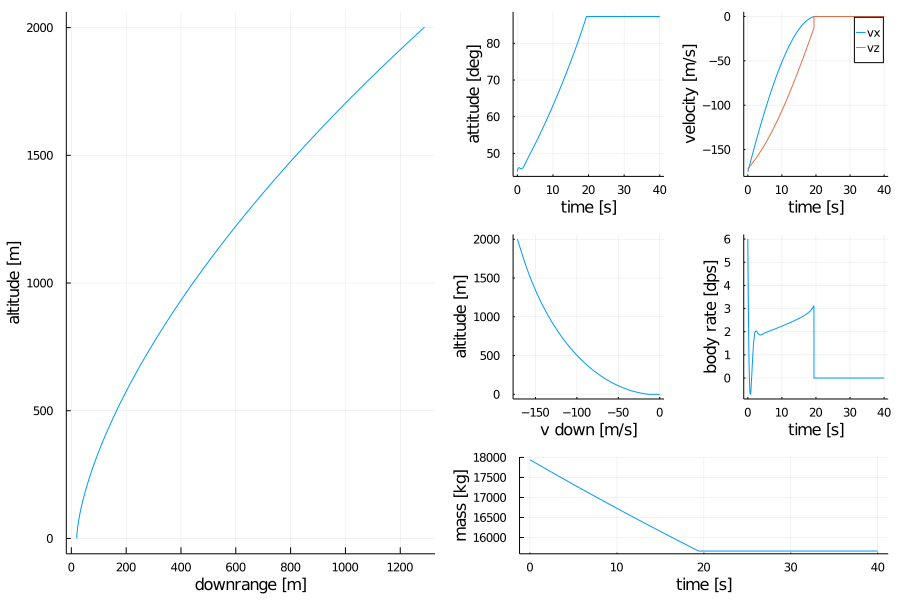

In [684]:
truth_plot(data)

In [685]:
function control_plot(data)
    o = data.controller.outputs
    d = data.controller.desired

    plot(
        plot(d.time, d.θ_error.*180/π, xlabel="time [s]", ylabel="att error [deg]", label=false),
        plot(d.time, d.ω_error.*180/π, xlabel="time [s]", ylabel="rate error [dps]", label=false),
        plot(o.time, o.δ_gim.*180/π, xlabel="time [s]", ylabel="gimbal [deg]", label=false),
        plot(o.time, o.T_thrust, xlabel="time [s]", ylabel="thrust [N]", label=false),
        plot(d.time, d.ω̇_des.*180/π, xlabel="time [s]", ylabel="wdot des [dpss]", label=false),
        size=(900, 600), layout=@layout([grid(2,1){0.5w} [b; c; d]])
    )
end

control_plot (generic function with 1 method)

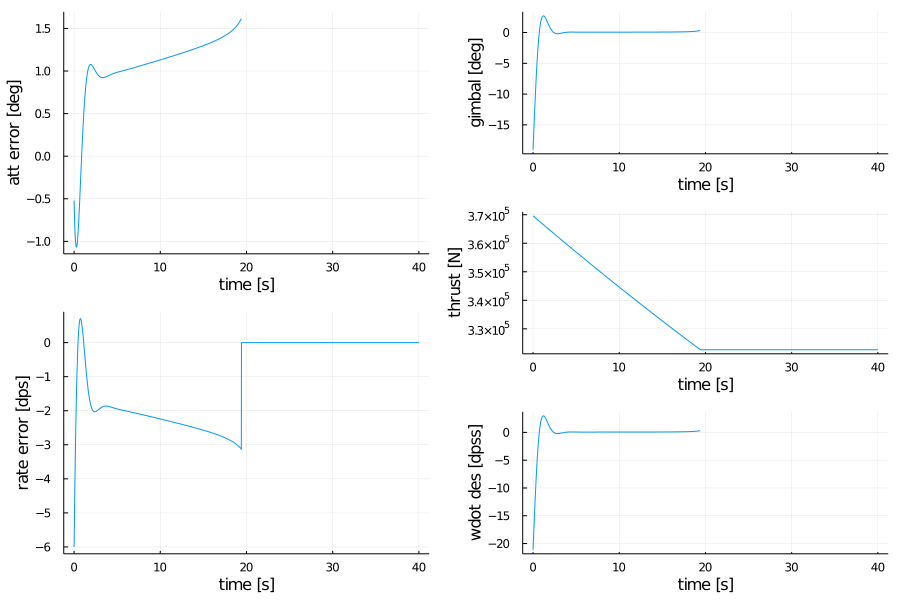

In [686]:
control_plot(data)

Clearly, the rocket lands close to the target, with low velocities/rates, and close to upright attitude.

### Planar Rocket Landimg w/ Flexible Modes Simulation

Now, lets make the simulation more complicated by adding some flex modes and
a sensor whose measurements are corrupted by this mode. This could correspond
to lateral bending modes or slosh.

In [711]:
using ControlSystems

function flex_system(flex_tf, s)
    ss_sys = ss(flex_tf)

    A = ss_sys.A
    B = ss_sys.B
    # Compute the output mapping for both θ and ω flex on the IMU
    C_θ = ss_sys.C
    C_ω = ss(flex_tf*s).C
    n = size(A, 2)

    return (SizedMatrix{n,n}(A), SizedVector{n}(B), SizedMatrix{2,n}(vcat(C_θ, C_ω)))
end

flex_system (generic function with 1 method)

In [688]:
@dynamics PlanarRocketLandingFlex{T, Nf} begin
    @integrable begin
        r::SVector{2, T} 
        v::SVector{2, T}
        θ::T
        ω::T
        m::T
        flex::SVector{Nf, T}
    end

    @direct begin
        landed::Bool
    end
end

PlanarRocketLandingFlex

In [709]:
function DynamicsAndControl.initialize(::Type{PlanarRocketLandingFlex}, config)
    x0 = config.x0

    # add the flex system matrices to the static data for use in the dynamics
    A_flex, B_flex, _ = config.flex_system
    n_flex = size(A_flex, 2)
    static = (;config.params..., A_flex, B_flex)

    return (x0.r, x0.v, x0.θ, x0.ω, x0.m, SA[zeros(n_flex)...]), (false,), static
end

In [690]:
function DynamicsAndControl.dynamics!(this::PlanarRocketLandingFlex, ẋ, x, u, t)
    @unpack Isp, J, t_hat_body, g0, r_gim2cg = static(this)
    @unpack A_flex, B_flex = static(this)
    @unpack r, v, θ, ω, m, flex, landed = x
    @unpack δ_gim, T_thrust = u

    f_thrust = T_thrust*RotMatrix(θ)*t_hat_body
    f_grav = SA[0.0, -m*g0]
    f_total = f_thrust + f_grav
    τ_gimbal = T_thrust*sin(δ_gim)*r_gim2cg
    
    if !landed
        ẋ.r = v
        ẋ.v = f_total/m
        ẋ.θ = ω
        ẋ.ω = τ_gimbal/J
        ẋ.m = -T_thrust/(Isp*g0)
        ẋ.flex = A_flex*flex + B_flex*τ_gimbal/J
    else
        ẋ.r = ẋ.v = SA[0.0, 0.0]
        ẋ.θ = ẋ.ω = ẋ.m = 0.0
        ẋ.flex = A_flex*flex
    end

    log!(this, :state, t, (a=ẋ.v, ω̇=ẋ.ω, ṁ=ẋ.m, r, v, θ, ω, m, flex))
    log!(this, :forces, t, (;f_thrust, f_grav, f_total, τ_gimbal))
end

function DynamicsAndControl.update!(this::PlanarRocketLandingFlex, ẋ, x, u, t)
    if(x.r[2] <= 0.0)
        x.landed = true
        x.v = SA[0.0, 0.0]
        x.ω = 0.0
        return true
    end
    
    return false
end

In [710]:
s = tf("s")
ωn_flex = 0.8*2π
ζ_flex = 0.01
flex_tf = ωn_flex^2/(s^2 + 2*ωn_flex*ζ_flex + ωn_flex^2)
flex_sys = flex_system(flex_tf, s)

dynamics_conf = (;
    dynamics_conf...,
    flex_system = flex_sys
)

(x0 = (r = [1288.5705974409814, 2001.7550218991737], v = [-174.99312755562536, -171.84482593257277], θ = 0.7853981633974483, ω = 0.10471975511965977, m = 17941.58360388262), params = (Isp = 300, g0 = 9.81, J = 5.0e6, r_gim2cg = 15.0, t_hat_body = [1.0, 0.0]), flex_system = ([0.0 1.0; -25.36671823170363 -0.0], [0.0, 1.0], [25.266187266788755 0.0; 0.0 25.266187266788755]))

Defining a sensor is similar to defining a controller (or an actuator).

In [693]:
@sensor RocketLandingSensorsFlex{T} begin
    @outputs begin
        θ_imu::T
        ω_imu::T
        v_nav::SVector{2, T}
        m_est::T
    end
end

RocketLandingSensorsFlex

In [694]:
@controller RocketLandingControllerFlex{T} begin
    @outputs begin
        δ_gim::T
        T_thrust::T
    end
end

RocketLandingControllerFlex

In [695]:
function DynamicsAndControl.initialize(::Type{RocketLandingSensorsFlex}, config)
    _, _, C_flex = config.flex_system

    # returns [initial sensor state], [initial sensor outputs], [static data named tuple]
    return (), (0.0, 0.0, SA[0.0, 0.0], 0.0), (; C_flex)
end

In [696]:
function DynamicsAndControl.update!(this::RocketLandingSensorsFlex, y, _, x, t)
    @unpack v, θ, ω, m, flex = x
    @unpack C_flex = static(this)

    # flex applies to imu measurements
    θ_flex, ω_flex = C_flex*flex
    θ_imu = θ + θ_flex
    ω_imu = ω + ω_flex

    # perfect sensing of velocity and mass
    v_nav = v
    m_est = m

    @pack! y = θ_imu, ω_imu, v_nav, m_est
    
    log!(this, :flex, t, (;θ_flex, ω_flex))
    log!(this, :outputs, t, (;θ_imu, ω_imu, v_nav, m_est))
end

In [697]:
DynamicsAndControl.initialize(::Type{RocketLandingControllerFlex}, config) = (), (0.0, 0.0), config

In [698]:
function DynamicsAndControl.update!(this::RocketLandingControllerFlex, u, _, y, t)
    @unpack v_nav, θ_imu, ω_imu, m_est = y
    @unpack Kp, Kd, T_W, g0, J, r_gim2cg = static(this)

    T_thrust = m_est*g0*T_W
    
    axial_des = -v_nav/norm(v_nav)
    axial_cur = RotMatrix(θ_imu)*SA[1.0, 0.0]
    θ_error = -cross(axial_des, axial_cur)
    ω_error = 0.0 - ω_imu
    ω̇_des = Kp*θ_error + Kd*ω_error
    δ_gim_raw = ω̇_des*J/(T_thrust*r_gim2cg)
    
    δ_gim = clamp(δ_gim_raw, -10*π/180, 10*π/180)

    @pack! u = T_thrust, δ_gim

    log!(this, :outputs, t, (;T_thrust, δ_gim))
    log!(this, :desired, t, (;ω̇_des, axial_des, axial_cur, θ_error, ω_error))
end

In [699]:
sensor_conf = (flex_system = flex_sys,)

(flex_system = ([0.0 1.0; -25.36671823170363 -0.0], [0.0, 1.0], [25.266187266788755 0.0; 0.0 25.266187266788755]),)

In [700]:
sim = Simulation(
    ( :truth, PlanarRocketLandingFlex, dynamics_conf ),
    ( :sensor, RocketLandingSensorsFlex, sensor_conf ),
    ( :controller, RocketLandingControllerFlex, control_conf ),
    40.0, RK4(), dt=0.001, control_dt=0.02
)

Simulation with dt=0.001, tspan=(0.0, 40.0), solver=RK4, components=
	dynamics: PlanarRocketLandingFlex
	sensor: RocketLandingSensorsFlex
	controller: RocketLandingControllerFlex
	actuator: DynamicsAndControl.PassthroughActuator


In [701]:
data = simulate(sim)

Simulation data set with immediate namespaces:
	[:sensor, :truth, :controller]


In [702]:
truth_plot(data)

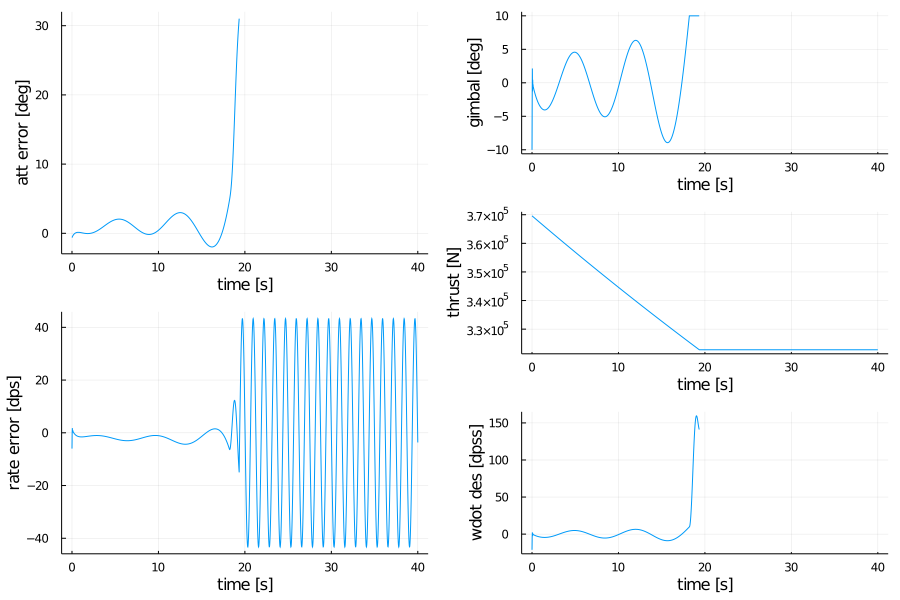

In [703]:
control_plot(data)

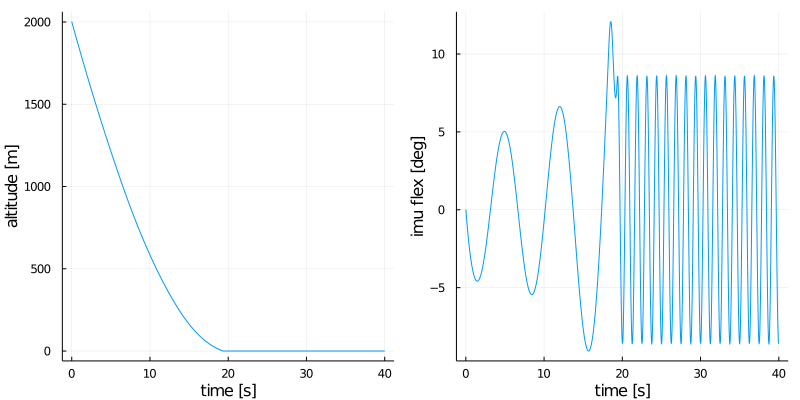

In [704]:
let p=data.truth.state, s=data.sensor.flex
    plot(
        plot(p.time, p.r[2], xlabel="time [s]", ylabel="altitude [m]"),
        plot(s.time, s.θ_flex.*180/π, xlabel="time [s]", ylabel="imu flex [deg]"),
        layout=(1,2), label="", size=(800, 400)
    )
end

Now, with the additional flex dynamics, attitude control is slightly unstable and
results in landing with a significant departure from the desired 90 degree
attitude.

TODO: implement a controller with a filter (requires a controller "state") to stabilize the attitude controller with the flex modes.